# 1. Setup

## 1-1. Library Setup

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from keras.utils import np_utils
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Input
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.metrics import AUC

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12620076676329159595
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16154099712
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5461483326220768594
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

In [3]:
!nvidia-smi

Tue Dec 14 03:13:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    37W / 250W |    375MiB / 16280MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


## 1-2. parameter setup

In [5]:
basemodel = 'DenseNet121'
image_size = 128
image_channels = 3
batch_size = 64
num_epochs = 100
class_num = 2
None_patience_num = 30
imagenet_patience_num = 20
S_all_labels = "S0", "S1"
T_all_labels = "T0", "T1"

#base_path = ''
base_path = 'gdrive/My Drive/Research_1_1_1/'

path_data = base_path + 'data_numpy/'
path_model_result = base_path + 'model_result/1 - Base_model_result/' + basemodel + '/'

In [6]:
S_model_name_imagenet = 'S_' + basemodel + '_imagenet'
S_model_name_None = 'S_' + basemodel + '_None'
T_model_name_imagenet = 'T_' + basemodel + '_imagenet'
T_model_name_None = 'T_' + basemodel + '_None'

print(S_model_name_None, S_model_name_imagenet, T_model_name_None, T_model_name_imagenet)

basemodel_list=[S_model_name_imagenet, S_model_name_None, T_model_name_imagenet, T_model_name_None]
basemodel_list

S_DenseNet121_None S_DenseNet121_imagenet T_DenseNet121_None T_DenseNet121_imagenet


['S_DenseNet121_imagenet',
 'S_DenseNet121_None',
 'T_DenseNet121_imagenet',
 'T_DenseNet121_None']

In [7]:
def createDirectory(name): 
    try: 
        if not os.path.exists(name): 
            os.makedirs(path_model_result + name) 
    except OSError: 
        print("Error: Failed to create the directory.")  
        
for i in basemodel_list:
    createDirectory(i)

# 2. Data Load and Image Check

## 2-1. Data Load

In [8]:
xTrain_S = np.load(path_data + 'xTrain_S.npy')
xValid_S = np.load(path_data + 'xValid_S.npy')
xTest_S = np.load(path_data + 'xTest_S.npy')

yTrain_S = np.load(path_data + 'yTrain_S.npy')
yValid_S = np.load(path_data + 'yValid_S.npy')
yTest_S = np.load(path_data + 'yTest_S.npy')

xTrain_T = np.load(path_data + 'xTrain_T.npy')
xValid_T = np.load(path_data + 'xValid_T.npy')
xTest_T = np.load(path_data + 'xTest_T.npy')

yTrain_T = np.load(path_data + 'yTrain_T.npy')
yValid_T = np.load(path_data + 'yValid_T.npy')
yTest_T = np.load(path_data + 'yTest_T.npy')

In [9]:
print(xTrain_S.shape, yTrain_S.shape)
print(xValid_S.shape, yValid_S.shape)
print(xTest_S.shape, yTest_S.shape)
print()
print(xTrain_T.shape, yTrain_T.shape)
print(xValid_T.shape, yValid_T.shape)
print(xTest_T.shape, yTest_T.shape)

(1920, 128, 128, 3) (1920, 1)
(640, 128, 128, 3) (640, 1)
(640, 128, 128, 3) (640, 1)

(1440, 128, 128, 3) (1440, 1)
(480, 128, 128, 3) (480, 1)
(480, 128, 128, 3) (480, 1)


In [10]:
xTrain_S = xTrain_S.astype('float32')/255
xValid_S = xValid_S.astype('float32')/255
xTest_S = xTest_S.astype('float32')/255

yTrain_S = np_utils.to_categorical(yTrain_S, class_num)
yValid_S = np_utils.to_categorical(yValid_S, class_num)
yTest_S = np_utils.to_categorical(yTest_S, class_num)

xTrain_T = xTrain_T.astype('float32')/255
xValid_T = xValid_T.astype('float32')/255
xTest_T = xTest_T.astype('float32')/255

yTrain_T = np_utils.to_categorical(yTrain_T, class_num)
yValid_T = np_utils.to_categorical(yValid_T, class_num)
yTest_T = np_utils.to_categorical(yTest_T, class_num)

In [11]:
print(xTrain_S.shape, yTrain_S.shape)
print(xValid_S.shape, yValid_S.shape)
print(xTest_S.shape, yTest_S.shape)
print()
print(xTrain_T.shape, yTrain_T.shape)
print(xValid_T.shape, yValid_T.shape)
print(xTest_T.shape, yTest_T.shape)

(1920, 128, 128, 3) (1920, 2)
(640, 128, 128, 3) (640, 2)
(640, 128, 128, 3) (640, 2)

(1440, 128, 128, 3) (1440, 2)
(480, 128, 128, 3) (480, 2)
(480, 128, 128, 3) (480, 2)


## 2-2. Image Check

xTrain_S image Numbers :  1920
xTrain_S image Numbers // 10 :  192
10


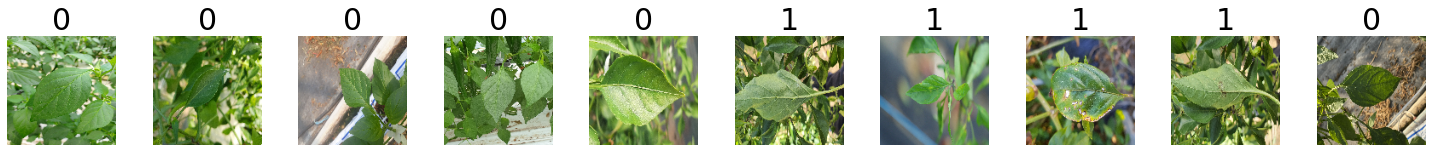

In [12]:
temp_S_a = len(xTrain_S)
print("xTrain_S image Numbers : ", temp_S_a)
temp_S_b = temp_S_a//10
print("xTrain_S image Numbers // 10 : ", temp_S_b)
temp_S_c = 0
for i in range(0, temp_S_a, temp_S_b):
    temp_S_c += 1
print(temp_S_c)


c=0
plt.figure(figsize=(20,3))
for i in range(0, temp_S_a, temp_S_b):
    plt.subplot(1, temp_S_c, c+1)
    plt.imshow(xTrain_S[i])
    plt.title(yTrain_S[i].argmax(),fontsize=30)
    plt.tight_layout()
    plt.axis('off')
    c+=1
plt.show()

xTrain_S image Numbers :  1440
xTrain_S image Numbers // 10 :  144
10


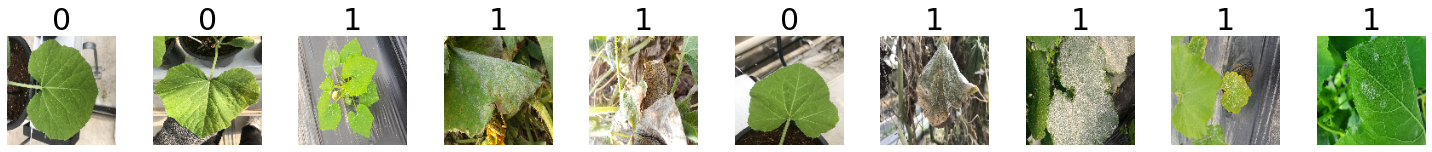

In [13]:
temp_T_a = len(xTrain_T)
print("xTrain_S image Numbers : ", temp_T_a)
temp_T_b = temp_T_a//10
print("xTrain_S image Numbers // 10 : ", temp_T_b)
temp_T_c = 0
for i in range(0, temp_T_a, temp_T_b):
    temp_T_c += 1
print(temp_T_c)


c=0
plt.figure(figsize=(20,3))
for i in range(0,temp_T_a,temp_T_b):
    plt.subplot(1, temp_T_c, c+1)
    plt.imshow(xTrain_T[i])
    plt.title(yTrain_T[i].argmax(),fontsize=30)
    plt.tight_layout()
    plt.axis('off')
    c+=1
plt.show()

# 3. Network Setting and Training

## 3-1. Network Setting

In [14]:
def feature_extractor_None(inp):
    base_model=tf.keras.applications.DenseNet121 (
                include_top=False, weights=None, input_tensor=inp)
    input = base_model.input
    out = base_model.layers[-1].output
    feature_output = tf.keras.layers.GlobalAveragePooling2D(name='feature')(out)
    return feature_output


def classifier_None(feature_output):
    out = feature_output
    out = Dense(128, activation="relu")(out)
    out = Dense(32, activation="relu")(out)
    classifier_output = Dense(class_num, activation="softmax", name="classifier_output")(out)
    return classifier_output


def model_None():
    inp = Input(shape=(image_size, image_size, image_channels))   
    feature_output = feature_extractor_None(inp)
    classifier_output = classifier_None(feature_output)
    model = Model(inputs=inp, outputs=classifier_output)
    return model

In [15]:
def feature_extractor_imagenet(inp):
    base_model=tf.keras.applications.DenseNet121 (
                include_top=False, weights='imagenet', input_tensor=inp)
    input = base_model.input
    out = base_model.layers[-1].output
    feature_output = tf.keras.layers.GlobalAveragePooling2D(name='feature')(out)
    return feature_output


def classifier_imagenet(feature_output):
    out = feature_output
    out = Dense(128, activation="relu")(out)
    out = Dense(32, activation="relu")(out)
    classifier_output = Dense(class_num, activation="softmax", name="classifier_output")(out)
    return classifier_output


def model_imagenet():
    inp = Input(shape=(image_size, image_size, image_channels))   
    feature_output = feature_extractor_imagenet(inp)
    classifier_output = classifier_imagenet(feature_output)
    model = Model(inputs=inp, outputs=classifier_output)
    return model

In [16]:
#plot_model(model_None())
#plot_model(model_imagenet())

## 3-2. Source Domain Training - weights=None

In [17]:
S_basemodel_None=model_None()
#S_basemodel_None.summary()

In [18]:
S_basemodel_None.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=None_patience_num, restore_best_weights=True)

S_basemodel_None_main =S_basemodel_None.fit(xTrain_S, yTrain_S, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_S, yValid_S), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(S_basemodel_None_main.history["val_accuracy"]) * 100))

Epoch 1/100
30/30 [==============================] - 31s 248ms/step - loss: 0.4063 - accuracy: 0.8125 - val_loss: 0.7697 - val_accuracy: 0.5094
Epoch 2/100
30/30 [==============================] - 4s 150ms/step - loss: 0.2577 - accuracy: 0.9010 - val_loss: 0.9812 - val_accuracy: 0.5031
Epoch 3/100
30/30 [==============================] - 5s 151ms/step - loss: 0.2038 - accuracy: 0.9297 - val_loss: 4.0770 - val_accuracy: 0.5000
Epoch 4/100
30/30 [==============================] - 5s 151ms/step - loss: 0.1716 - accuracy: 0.9359 - val_loss: 3.9205 - val_accuracy: 0.5000
Epoch 5/100
30/30 [==============================] - 5s 167ms/step - loss: 0.1741 - accuracy: 0.9375 - val_loss: 1.6320 - val_accuracy: 0.3688
Epoch 6/100
30/30 [==============================] - 5s 160ms/step - loss: 0.1434 - accuracy: 0.9453 - val_loss: 1.7757 - val_accuracy: 0.4812
Epoch 7/100
30/30 [==============================] - 4s 150ms/step - loss: 0.1362 - accuracy: 0.9542 - val_loss: 1.1576 - val_accuracy: 0.407

In [19]:
S_basemodel_None_df = pd.DataFrame(S_basemodel_None_main.history)
S_basemodel_None_df.to_csv( path_model_result + S_model_name_None + '/' + S_model_name_None + '_df.csv' )
S_basemodel_None_df

,loss,accuracy,val_loss,val_accuracy
0,0.406276,0.812500,0.769663,0.509375
1,0.257737,0.901042,0.981201,0.503125
2,0.203767,0.929688,4.076952,0.500000
3,0.171598,0.935938,3.920464,0.500000
4,0.174094,0.937500,1.631952,0.368750
...,...,...,...,...
95,0.000455,1.000000,0.148373,0.970312
96,0.001088,1.000000,0.137517,0.976562
97,0.003143,0.998958,1.941852,0.804688
98,0.026638,0.991667,2.190623,0.751562


Minimum validation loss: 0.08856914937496185
Maximum validation accuracy: 0.984375


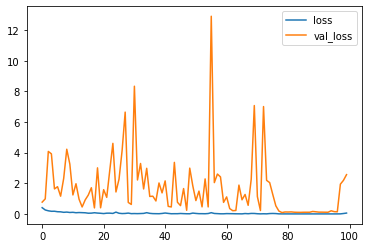

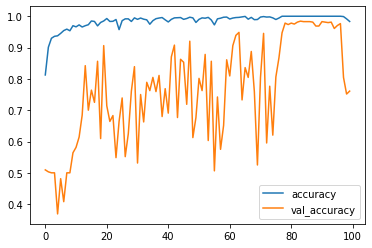

In [20]:
S_basemodel_None_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + S_model_name_None + '/' + S_model_name_None + '_loss,val_loss.png')
S_basemodel_None_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + S_model_name_None + '/' + S_model_name_None + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(S_basemodel_None_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(S_basemodel_None_df['val_accuracy'].max()))

In [21]:
print("Evaluate on test data")
S_basemodel_None_results = S_basemodel_None.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", S_basemodel_None_results)

Evaluate on test data
20/20 [==============================] - 3s 34ms/step - loss: 2.5018 - accuracy: 0.7609
test loss, test acc: [2.5018067359924316, 0.760937511920929]


In [22]:
S_basemodel_None_pred_Y = S_basemodel_None.predict(xTest_S, verbose = True)

20/20 [==============================] - 3s 33ms/step


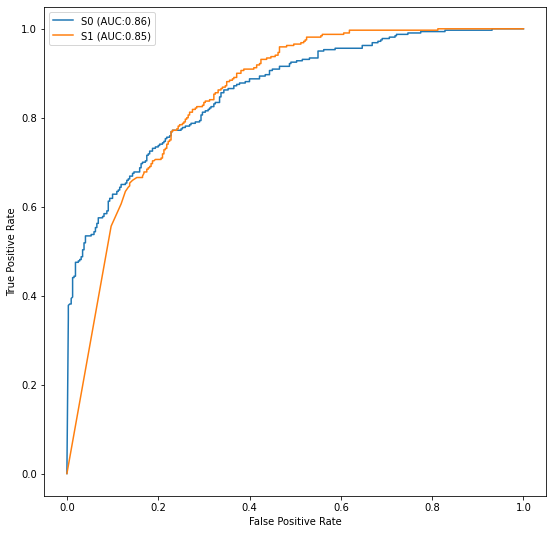

In [23]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(S_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_S[:,idx].astype(int), S_basemodel_None_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + S_model_name_None + '/' + S_model_name_None +'_TESTSET_AUC.png' )

## 3-3. Source Domain Training - weights='imagenet'

In [24]:
S_basemodel_imagenet=model_imagenet()
#S_basemodel_None.summary()

29097984/29084464 [==============================] - 0s 0us/step


In [25]:
S_basemodel_imagenet.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=imagenet_patience_num, restore_best_weights=True)

S_basemodel_imagenet_main =S_basemodel_imagenet.fit(xTrain_S, yTrain_S, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_S, yValid_S), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(S_basemodel_imagenet_main.history["val_accuracy"]) * 100))

Epoch 1/100
30/30 [==============================] - 20s 238ms/step - loss: 0.2138 - accuracy: 0.9172 - val_loss: 0.3693 - val_accuracy: 0.8344
Epoch 2/100
30/30 [==============================] - 4s 150ms/step - loss: 0.0778 - accuracy: 0.9729 - val_loss: 5.3328 - val_accuracy: 0.7281
Epoch 3/100
30/30 [==============================] - 5s 151ms/step - loss: 0.0218 - accuracy: 0.9943 - val_loss: 0.5737 - val_accuracy: 0.8297
Epoch 4/100
30/30 [==============================] - 5s 151ms/step - loss: 0.0400 - accuracy: 0.9880 - val_loss: 1.5577 - val_accuracy: 0.7281
Epoch 5/100
30/30 [==============================] - 5s 151ms/step - loss: 0.0619 - accuracy: 0.9812 - val_loss: 3.9054 - val_accuracy: 0.6812
Epoch 6/100
30/30 [==============================] - 4s 150ms/step - loss: 0.0215 - accuracy: 0.9922 - val_loss: 1.5674 - val_accuracy: 0.7516
Epoch 7/100
30/30 [==============================] - 5s 157ms/step - loss: 0.0057 - accuracy: 0.9979 - val_loss: 0.7075 - val_accuracy: 0.837

In [26]:
S_basemodel_imagenet_df = pd.DataFrame(S_basemodel_imagenet_main.history)
S_basemodel_imagenet_df.to_csv( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_df.csv' )
S_basemodel_imagenet_df

,loss,accuracy,val_loss,val_accuracy
0,0.213803,0.917188,0.369328,0.834375
1,0.077816,0.972917,5.332755,0.728125
2,0.021782,0.994271,0.573665,0.829687
3,0.040038,0.988021,1.557708,0.728125
4,0.061911,0.981250,3.905407,0.681250
...,...,...,...,...
62,0.006364,0.997396,0.160627,0.950000
63,0.006238,0.997396,0.053478,0.981250
64,0.007039,0.996354,3.122706,0.696875
65,0.013995,0.995833,0.384074,0.900000


Minimum validation loss: 0.016881750896573067
Maximum validation accuracy: 0.996874988079071


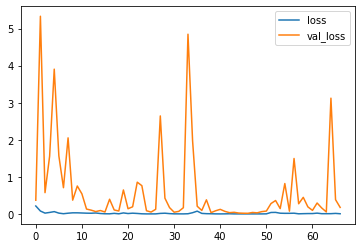

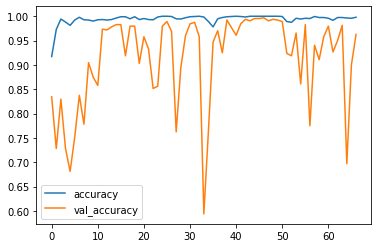

In [27]:
S_basemodel_imagenet_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_loss,val_loss.png')
S_basemodel_imagenet_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(S_basemodel_imagenet_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(S_basemodel_imagenet_df['val_accuracy'].max()))

In [28]:
print("Evaluate on test data")
S_model_name_imagenet_results = S_basemodel_imagenet.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", S_model_name_imagenet_results)

Evaluate on test data
20/20 [==============================] - 3s 34ms/step - loss: 0.0480 - accuracy: 0.9906
test loss, test acc: [0.048043619841337204, 0.9906250238418579]


In [29]:
S_model_name_imagenet_pred_Y = S_basemodel_imagenet.predict(xTest_S, verbose = True)

20/20 [==============================] - 3s 32ms/step


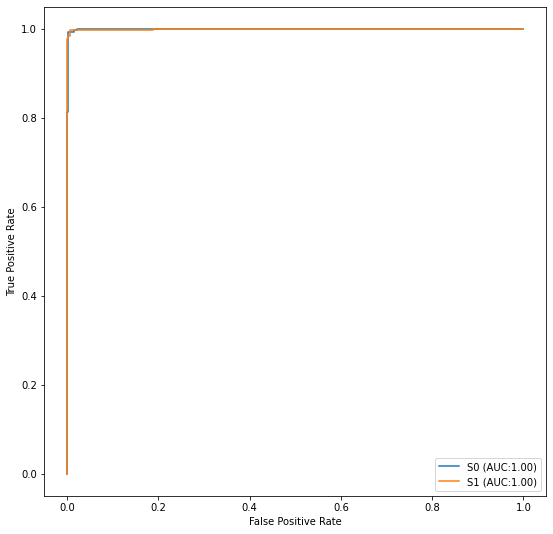

In [30]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(S_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_S[:,idx].astype(int), S_model_name_imagenet_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet +'_TESTSET_AUC.png' )

## 3-4. Target Domain Training - weights=None

In [31]:
T_basemodel_None=model_None()
#S_basemodel_None.summary()

In [32]:
T_basemodel_None.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=None_patience_num, restore_best_weights=True)

T_basemodel_None_main =T_basemodel_None.fit(xTrain_T, yTrain_T, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_T, yValid_T), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(T_basemodel_None_main.history["val_accuracy"]) * 100))

Epoch 1/100
23/23 [==============================] - 20s 288ms/step - loss: 0.2639 - accuracy: 0.8771 - val_loss: 0.7669 - val_accuracy: 0.4417
Epoch 2/100
23/23 [==============================] - 4s 163ms/step - loss: 0.0742 - accuracy: 0.9757 - val_loss: 3.2219 - val_accuracy: 0.4979
Epoch 3/100
23/23 [==============================] - 4s 155ms/step - loss: 0.0792 - accuracy: 0.9743 - val_loss: 2.1088 - val_accuracy: 0.4771
Epoch 4/100
23/23 [==============================] - 4s 163ms/step - loss: 0.0975 - accuracy: 0.9701 - val_loss: 6.4454 - val_accuracy: 0.5000
Epoch 5/100
23/23 [==============================] - 4s 164ms/step - loss: 0.0247 - accuracy: 0.9944 - val_loss: 2.1164 - val_accuracy: 0.5063
Epoch 6/100
23/23 [==============================] - 4s 156ms/step - loss: 0.0268 - accuracy: 0.9903 - val_loss: 7.2589 - val_accuracy: 0.5000
Epoch 7/100
23/23 [==============================] - 4s 156ms/step - loss: 0.0302 - accuracy: 0.9896 - val_loss: 2.6225 - val_accuracy: 0.506

In [33]:
T_basemodel_None_df = pd.DataFrame(T_basemodel_None_main.history)
T_basemodel_None_df.to_csv( path_model_result + T_model_name_None + '/' + T_model_name_None + '_df.csv' )
T_basemodel_None_df

,loss,accuracy,val_loss,val_accuracy
0,0.263915,0.877083,0.766857,0.441667
1,0.074205,0.975694,3.221867,0.497917
2,0.079192,0.974306,2.108772,0.477083
3,0.097535,0.970139,6.445387,0.500000
4,0.024669,0.994444,2.116389,0.506250
...,...,...,...,...
95,0.044398,0.984722,28.214502,0.500000
96,0.029835,0.992361,8.001575,0.562500
97,0.009769,0.996528,0.129341,0.964583
98,0.007779,0.997917,3.196356,0.712500


Minimum validation loss: 0.05765924230217934
Maximum validation accuracy: 0.987500011920929


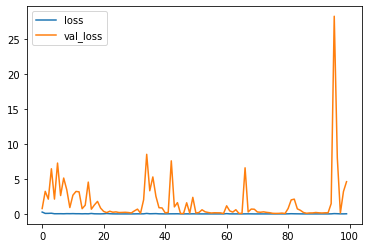

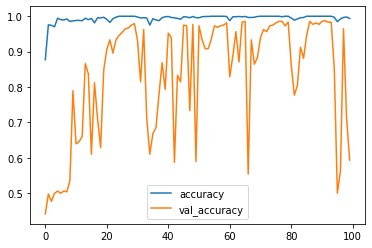

In [34]:
T_basemodel_None_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + T_model_name_None + '/' + T_model_name_None + '_loss,val_loss.png')
T_basemodel_None_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + T_model_name_None + '/' + T_model_name_None + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(T_basemodel_None_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(T_basemodel_None_df['val_accuracy'].max()))

In [35]:
print("Evaluate on test data")
T_basemodel_None_results = T_basemodel_None.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", T_basemodel_None_results)

Evaluate on test data
15/15 [==============================] - 3s 36ms/step - loss: 4.3477 - accuracy: 0.6292
test loss, test acc: [4.347671985626221, 0.6291666626930237]


In [36]:
T_basemodel_None_pred_Y = T_basemodel_None.predict(xTest_T, verbose = True)

15/15 [==============================] - 3s 32ms/step


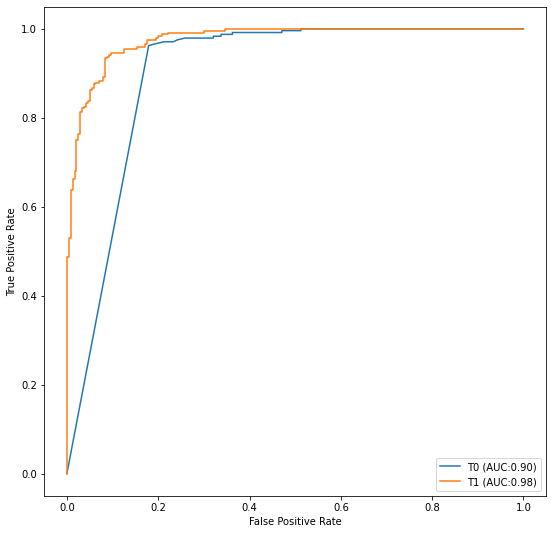

In [37]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(T_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_T[:,idx].astype(int), T_basemodel_None_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + T_model_name_None + '/' + T_model_name_None + '_TESTSET_AUC.png' )

## 3-5. Target Domain Training - weights='imagenet'

In [38]:
T_basemodel_imagenet=model_imagenet()
#S_basemodel_None.summary()

In [39]:
T_basemodel_imagenet.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=imagenet_patience_num, restore_best_weights=True)

T_basemodel_imagenet_main =T_basemodel_imagenet.fit(xTrain_T, yTrain_T, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_T, yValid_T), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(T_basemodel_imagenet_main.history["val_accuracy"]) * 100))

Epoch 1/100
23/23 [==============================] - 19s 267ms/step - loss: 0.1245 - accuracy: 0.9410 - val_loss: 0.7119 - val_accuracy: 0.8896
Epoch 2/100
23/23 [==============================] - 4s 156ms/step - loss: 0.0439 - accuracy: 0.9840 - val_loss: 6.3323 - val_accuracy: 0.5208
Epoch 3/100
23/23 [==============================] - 4s 156ms/step - loss: 0.0255 - accuracy: 0.9896 - val_loss: 1.0271 - val_accuracy: 0.8083
Epoch 4/100
23/23 [==============================] - 4s 162ms/step - loss: 0.0148 - accuracy: 0.9944 - val_loss: 0.7447 - val_accuracy: 0.8938
Epoch 5/100
23/23 [==============================] - 4s 164ms/step - loss: 0.0029 - accuracy: 0.9993 - val_loss: 0.4833 - val_accuracy: 0.9021
Epoch 6/100
23/23 [==============================] - 4s 163ms/step - loss: 1.2738e-04 - accuracy: 1.0000 - val_loss: 0.3470 - val_accuracy: 0.9187
Epoch 7/100
23/23 [==============================] - 4s 163ms/step - loss: 8.9445e-05 - accuracy: 1.0000 - val_loss: 0.1950 - val_accurac

In [40]:
T_basemodel_imagenet_df = pd.DataFrame(T_basemodel_imagenet_main.history)
T_basemodel_imagenet_df.to_csv( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_df.csv' )
T_basemodel_imagenet_df

,loss,accuracy,val_loss,val_accuracy
0,0.124468,0.940972,0.711851,0.889583
1,0.043947,0.984028,6.332298,0.520833
2,0.025519,0.989583,1.027149,0.808333
3,0.014755,0.994444,0.744687,0.893750
4,0.002921,0.999306,0.483301,0.902083
5,0.000127,1.000000,0.346990,0.918750
6,0.000089,1.000000,0.194980,0.945833
7,0.000081,1.000000,0.125556,0.964583
8,0.000177,1.000000,0.058790,0.987500
9,0.000041,1.000000,0.039022,0.991667


Minimum validation loss: 0.0001988543226616457
Maximum validation accuracy: 1.0


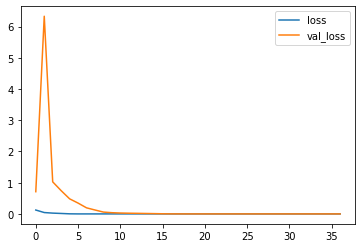

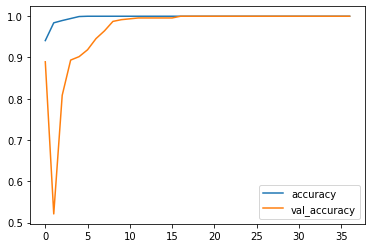

In [41]:
T_basemodel_imagenet_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_loss,val_loss.png')
T_basemodel_imagenet_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(T_basemodel_imagenet_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(T_basemodel_imagenet_df['val_accuracy'].max()))

In [42]:
print("Evaluate on test data")
T_model_name_imagenet_results = T_basemodel_imagenet.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", T_model_name_imagenet_results)

Evaluate on test data
15/15 [==============================] - 3s 34ms/step - loss: 0.0054 - accuracy: 0.9979
test loss, test acc: [0.005384038668125868, 0.9979166388511658]


In [43]:
T_model_name_imagenet_pred_Y = T_basemodel_imagenet.predict(xTest_T, verbose = True)

15/15 [==============================] - 3s 35ms/step


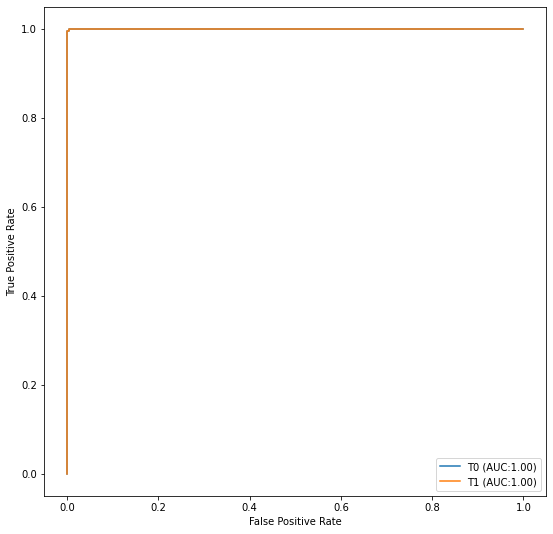

In [44]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(T_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_T[:,idx].astype(int), T_model_name_imagenet_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_TESTSET_AUC.png' )

# 4. Result Report

In [45]:
print(S_model_name_None)
print("test loss, test acc:", S_basemodel_None_results)

S_DenseNet121_None
test loss, test acc: [2.5018067359924316, 0.760937511920929]


In [46]:
print(S_model_name_imagenet)
print("test loss, test acc:", S_model_name_imagenet_results)

S_DenseNet121_imagenet
test loss, test acc: [0.048043619841337204, 0.9906250238418579]


In [47]:
print(T_model_name_None)
print("test loss, test acc:", T_basemodel_None_results)

T_DenseNet121_None
test loss, test acc: [4.347671985626221, 0.6291666626930237]


In [48]:
print(T_model_name_imagenet)
print("test loss, test acc:", T_model_name_imagenet_results)

T_DenseNet121_imagenet
test loss, test acc: [0.005384038668125868, 0.9979166388511658]


# 5. Source Domain Training Model ↔ Target Domain Training Model 상호 Test Data Set 평가 

In [49]:
print( S_model_name_None + " →→→ Target Test")
S_basemodel_None_results_T = S_basemodel_None.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", S_basemodel_None_results_T)

S_DenseNet121_None →→→ Target Test
15/15 [==============================] - 1s 36ms/step - loss: 4.1931 - accuracy: 0.6250
test loss, test acc: [4.193099498748779, 0.625]


In [50]:
print( S_model_name_imagenet + " →→→ Target Test")
S_model_name_imagenet_results_T = S_basemodel_imagenet.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", S_model_name_imagenet_results_T)

S_DenseNet121_imagenet →→→ Target Test
15/15 [==============================] - 1s 36ms/step - loss: 3.9113 - accuracy: 0.6438
test loss, test acc: [3.911284923553467, 0.643750011920929]


In [51]:
print( T_model_name_None + " →→→ Source Test")
T_basemodel_None_results_S = T_basemodel_None.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", T_basemodel_None_results_S)

T_DenseNet121_None →→→ Source Test
20/20 [==============================] - 1s 35ms/step - loss: 4.6901 - accuracy: 0.5641
test loss, test acc: [4.690061569213867, 0.5640624761581421]


In [52]:
print( T_model_name_imagenet + " →→→ Source Test")
T_model_name_imagenet_results_S = T_basemodel_imagenet.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", T_model_name_imagenet_results_S)

T_DenseNet121_imagenet →→→ Source Test
20/20 [==============================] - 1s 35ms/step - loss: 1.6705 - accuracy: 0.7203
test loss, test acc: [1.6704543828964233, 0.7203124761581421]


# 6. Model Save 

In [53]:
S_basemodel_None.save( path_model_result + S_model_name_None + '/' + S_model_name_None + '.h5' )
S_basemodel_imagenet.save( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '.h5' )
T_basemodel_None.save( path_model_result + T_model_name_None + '/' + T_model_name_None + '.h5' )
T_basemodel_imagenet.save( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '.h5' )